In [7]:
#connecting Google Drive with Colab
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [39]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=e6d431c0-5a6f-43d5-83e8-128ead11807e
To: /content/brain_tumor.zip
100% 156M/156M [00:02<00:00, 61.6MB/s]


In [40]:
!unzip -q brain_tumor.zip

In [41]:
ls -l

total 152156
-rw-r--r-- 1 root root 155791278 Apr 22 18:49 brain_tumor.zip
drwx------ 6 root root      4096 Apr 22 14:27 gdrive/
drwxr-xr-x 1 root root      4096 Apr 18 13:25 sample_data/
drwxr-xr-x 6 root root      4096 Apr 22 18:50 Testing/
drwxr-xr-x 6 root root      4096 Apr 22 18:50 Training/


In [42]:
!sudo apt-get install tree


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (101 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 131015 files and directories currently install

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)



TF Version: 2.15.0


In [44]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

In [45]:
# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128
    )

    test_labels = []
    predictions = []

    for imgs, labels in test_ds.take(100): #tqdm(test_ds.take(100), desc='Predicting on Test Data')
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions

In [46]:
def model_training_and_evaluation (model, train_ds, val_ds, epochs, class_weights=None, callbacks=None, opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)):

    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      class_weight = class_weights,
      callbacks=callbacks,
    )

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    y_true, y_pred_array = eval_model_on_test(model)

    y_pred = [np.argmax(prediction, axis = 0) for prediction in y_pred_array]

    y_true_classes = [classes[x] for x in y_true]
    y_pred_classes = [classes[x] for x in y_pred]
    print(f"Baseline Accuracy: {accuracy_score(y_true_classes, y_pred_classes)*100:.2f}%\n")
    print(classification_report(y_true_classes, y_pred_classes))


    return pd.DataFrame(confusion_matrix(y_true_classes, y_pred_classes), columns=classes, index=classes)

In [47]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

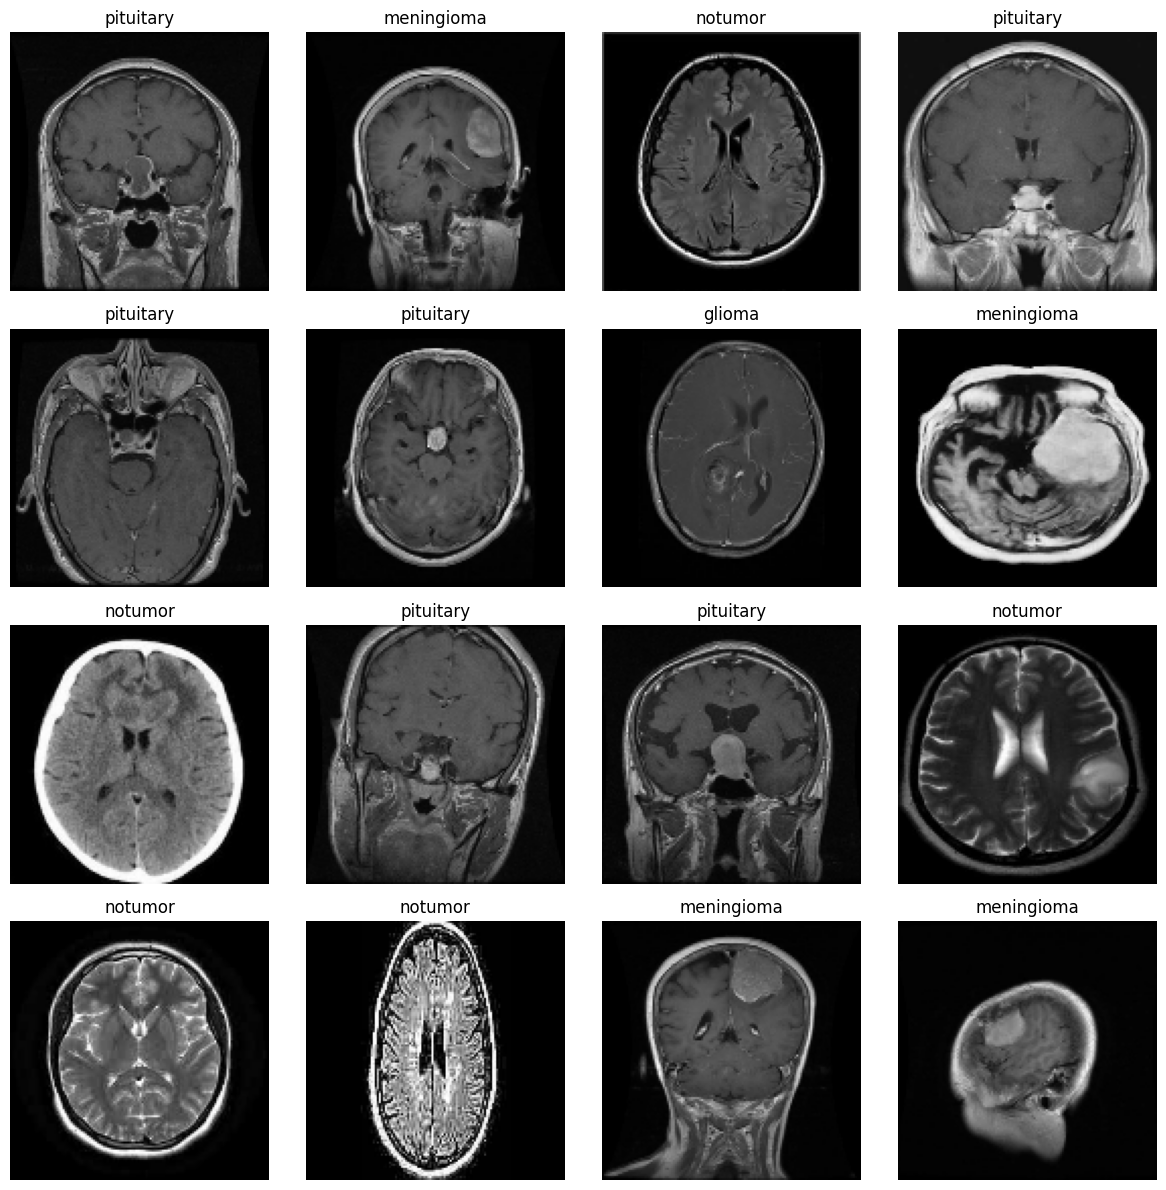

In [49]:
plt.figure(figsize=(12, 12), dpi=100)

for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title((classes[labels[i]]))
        plt.axis("off")
plt.tight_layout()

In [50]:
# Baseline CNN model with 3 layers

num_classes = len(classes)
img_height, img_width = IMG_DIMS

baseline_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [51]:
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)       

In [52]:
# Train Baseline Model

epochs=10
history = baseline_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
143/143 [==============================] - 120s 821ms/step - loss: 0.6601 - accuracy: 0.7339 - val_loss: 0.4098 - val_accuracy: 0.8336
Epoch 2/10
143/143 [==============================] - 96s 674ms/step - loss: 0.3589 - accuracy: 0.8597 - val_loss: 0.3426 - val_accuracy: 0.8669
Epoch 3/10
143/143 [==============================] - 82s 571ms/step - loss: 0.2284 - accuracy: 0.9171 - val_loss: 0.2825 - val_accuracy: 0.9089
Epoch 4/10
143/143 [==============================] - 81s 567ms/step - loss: 0.1476 - accuracy: 0.9479 - val_loss: 0.2408 - val_accuracy: 0.9221
Epoch 5/10
143/143 [==============================] - 79s 553ms/step - loss: 0.1011 - accuracy: 0.9665 - val_loss: 0.2741 - val_accuracy: 0.9124
Epoch 6/10
143/143 [==============================] - 79s 551ms/step - loss: 0.0655 - accuracy: 0.9764 - val_loss: 0.2551 - val_accuracy: 0.9273
Epoch 7/10
143/143 [==============================] - 78s 541ms/step - loss: 0.0585 - accuracy: 0.9827 - val_loss: 0.2549 - val_a

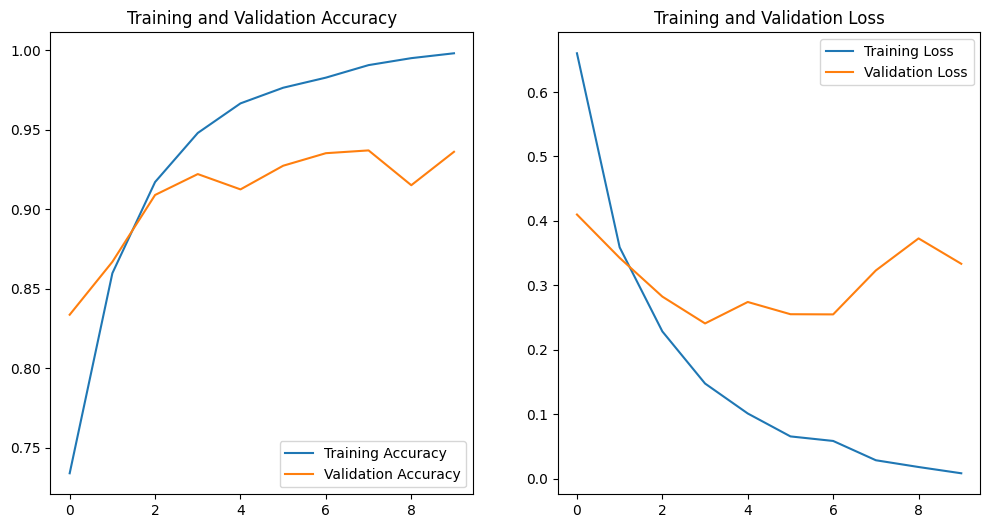

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
baseline_y_true, baseline_y_pred_array = eval_model_on_test(baseline_model)

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 210ms/step


In [55]:
baseline_y_pred = [np.argmax(prediction, axis = 0) for prediction in baseline_y_pred_array]

In [56]:
baseline_y_true_classes = [classes[x] for x in baseline_y_true]
baseline_y_pred_classes = [classes[x] for x in baseline_y_pred]
print(f"Baseline Accuracy: {accuracy_score(baseline_y_true_classes, baseline_y_pred_classes)*100:.2f}%\n")
print(classification_report(baseline_y_true_classes, baseline_y_pred_classes))
pd.DataFrame(confusion_matrix(baseline_y_true_classes, baseline_y_pred_classes))

Baseline Accuracy: 94.74%

              precision    recall  f1-score   support

      glioma       0.97      0.88      0.92       300
  meningioma       0.87      0.92      0.90       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



,0,1,2,3
0,263,36,0,1
1,7,282,13,4
2,2,2,401,0
3,0,4,0,296


In [59]:
# Baseline Model with Random Flip

num_classes = len(classes)
img_height, img_width = IMG_DIMS


aug_baseline_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])



Epoch 1/10
143/143 [==============================] - 86s 595ms/step - loss: 0.7601 - accuracy: 0.6834 - val_loss: 0.6718 - val_accuracy: 0.7329
Epoch 2/10
143/143 [==============================] - 80s 555ms/step - loss: 0.4668 - accuracy: 0.8212 - val_loss: 0.4991 - val_accuracy: 0.8091
Epoch 3/10
143/143 [==============================] - 81s 566ms/step - loss: 0.3542 - accuracy: 0.8672 - val_loss: 0.4252 - val_accuracy: 0.8363
Epoch 4/10
143/143 [==============================] - 80s 560ms/step - loss: 0.2877 - accuracy: 0.8923 - val_loss: 0.2800 - val_accuracy: 0.8984
Epoch 5/10
143/143 [==============================] - 80s 563ms/step - loss: 0.2205 - accuracy: 0.9208 - val_loss: 0.3019 - val_accuracy: 0.8862
Epoch 6/10
143/143 [==============================] - 81s 568ms/step - loss: 0.1895 - accuracy: 0.9284 - val_loss: 0.2388 - val_accuracy: 0.9116
Epoch 7/10
143/143 [==============================] - 80s 560ms/step - loss: 0.1571 - accuracy: 0.9453 - val_loss: 0.2575 - val_ac

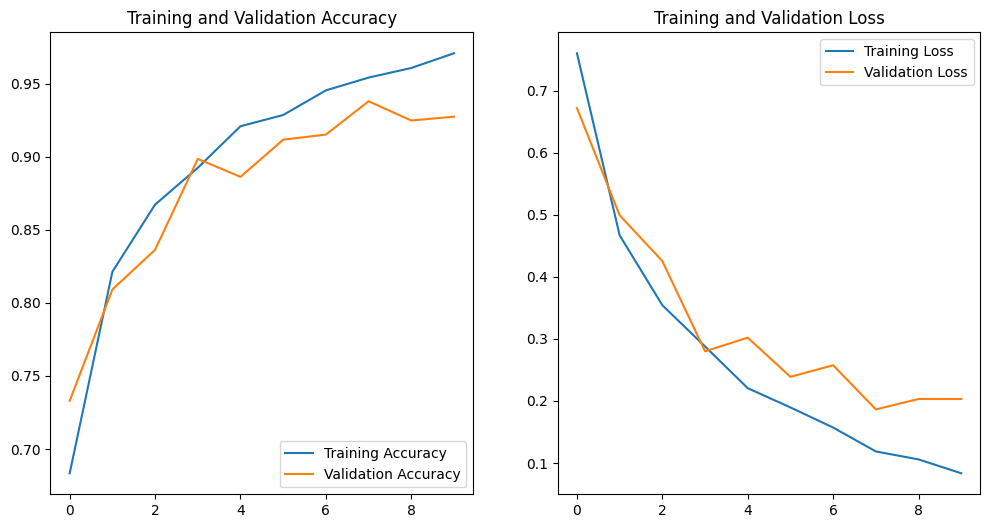

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 202ms/step
Baseline Accuracy: 93.97%

              precision    recall  f1-score   support

      glioma       0.93      0.89      0.91       300
  meningioma       0.87      0.91      0.89       306
     notumor       0.98      0.97      0.98       405
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



,glioma,meningioma,notumor,pituitary
glioma,267,28,0,5
meningioma,17,277,8,4
notumor,3,9,393,0
pituitary,1,4,0,295


In [60]:
epochs = 10
model_training_and_evaluation(aug_baseline_model, train_ds, val_ds, epochs)

Epoch 1/10
143/143 [==============================] - 81s 562ms/step - loss: 0.8593 - accuracy: 0.6328 - val_loss: 0.6133 - val_accuracy: 0.7732
Epoch 2/10
143/143 [==============================] - 80s 560ms/step - loss: 0.5494 - accuracy: 0.7867 - val_loss: 0.6354 - val_accuracy: 0.7548
Epoch 3/10
143/143 [==============================] - 77s 540ms/step - loss: 0.4768 - accuracy: 0.8140 - val_loss: 0.5245 - val_accuracy: 0.8065
Epoch 4/10
143/143 [==============================] - 84s 590ms/step - loss: 0.4123 - accuracy: 0.8394 - val_loss: 0.4246 - val_accuracy: 0.8634
Epoch 5/10
143/143 [==============================] - 79s 550ms/step - loss: 0.3792 - accuracy: 0.8545 - val_loss: 0.5058 - val_accuracy: 0.8152
Epoch 6/10
143/143 [==============================] - 80s 562ms/step - loss: 0.3405 - accuracy: 0.8681 - val_loss: 0.4039 - val_accuracy: 0.8625
Epoch 7/10
143/143 [==============================] - 79s 552ms/step - loss: 0.3279 - accuracy: 0.8761 - val_loss: 0.3823 - val_ac

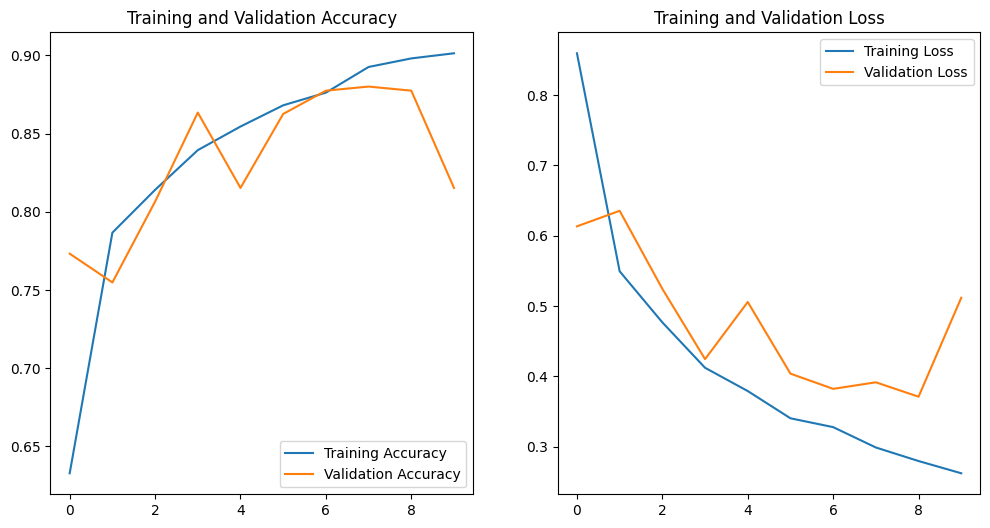

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 344ms/step
Baseline Accuracy: 79.02%

              precision    recall  f1-score   support

      glioma       0.92      0.67      0.78       300
  meningioma       0.71      0.68      0.70       306
     notumor       0.72      0.98      0.83       405
   pituitary       0.93      0.77      0.84       300

    accuracy                           0.79      1311
   macro avg       0.82      0.77      0.79      1311
weighted avg       0.81      0.79      0.79      1311



,glioma,meningioma,notumor,pituitary
glioma,201,63,30,6
meningioma,15,208,72,11
notumor,2,7,395,1
pituitary,0,13,55,232


In [61]:
# Baseline Model with Random Rotation

aug_baseline_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.RandomRotation(0.2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model_training_and_evaluation(aug_baseline_model, train_ds, val_ds, epochs)

Epoch 1/10
143/143 [==============================] - 73s 503ms/step - loss: 2.8683 - accuracy: 0.2737 - val_loss: 1.3791 - val_accuracy: 0.3047
Epoch 2/10
143/143 [==============================] - 73s 514ms/step - loss: 1.3854 - accuracy: 0.2729 - val_loss: 1.3791 - val_accuracy: 0.3047
Epoch 3/10
143/143 [==============================] - 74s 516ms/step - loss: 1.3849 - accuracy: 0.2729 - val_loss: 1.3800 - val_accuracy: 0.3047
Epoch 4/10
143/143 [==============================] - 70s 492ms/step - loss: 1.3848 - accuracy: 0.2729 - val_loss: 1.3806 - val_accuracy: 0.3047
Epoch 5/10
143/143 [==============================] - 72s 502ms/step - loss: 1.3848 - accuracy: 0.2729 - val_loss: 1.3797 - val_accuracy: 0.3047
Epoch 6/10
143/143 [==============================] - 72s 503ms/step - loss: 1.3851 - accuracy: 0.2729 - val_loss: 1.3798 - val_accuracy: 0.3047
Epoch 7/10
143/143 [==============================] - 71s 498ms/step - loss: 1.3848 - accuracy: 0.2729 - val_loss: 1.3801 - val_ac

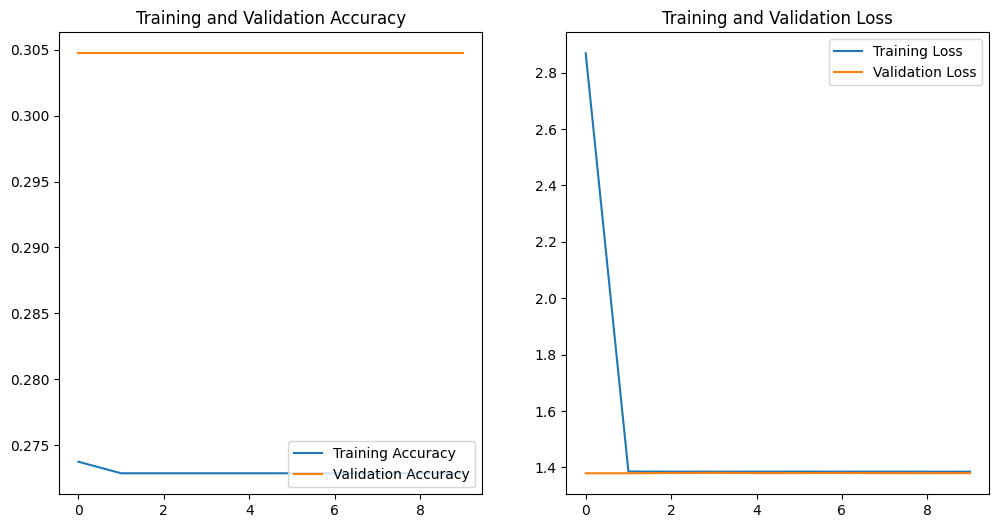

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 205ms/step
Baseline Accuracy: 30.89%

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.31      1.00      0.47       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,glioma,meningioma,notumor,pituitary
glioma,0,0,300,0
meningioma,0,0,306,0
notumor,0,0,405,0
pituitary,0,0,300,0


In [62]:
# Baseline Model with Data Augmentation

aug_baseline_model_2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.RandomBrightness(factor=0.2), #value_range=(0, 255), seed=42)
  layers.Conv2D(16, 3, padding='same', activation='relu'), # additional to a 3x3 patch size, use stride!
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model_training_and_evaluation(aug_baseline_model_2, train_ds, val_ds, epochs)

Epoch 1/10
143/143 [==============================] - 75s 520ms/step - loss: 0.8178 - accuracy: 0.6862 - val_loss: 0.5309 - val_accuracy: 0.7907
Epoch 2/10
143/143 [==============================] - 80s 560ms/step - loss: 0.4434 - accuracy: 0.8346 - val_loss: 0.4354 - val_accuracy: 0.8529
Epoch 3/10
143/143 [==============================] - 73s 512ms/step - loss: 0.3353 - accuracy: 0.8733 - val_loss: 0.3862 - val_accuracy: 0.8538
Epoch 4/10
143/143 [==============================] - 73s 511ms/step - loss: 0.2527 - accuracy: 0.9077 - val_loss: 0.3423 - val_accuracy: 0.8897
Epoch 5/10
143/143 [==============================] - 75s 522ms/step - loss: 0.1956 - accuracy: 0.9302 - val_loss: 0.4447 - val_accuracy: 0.8564
Epoch 6/10
143/143 [==============================] - 75s 522ms/step - loss: 0.1527 - accuracy: 0.9442 - val_loss: 0.3563 - val_accuracy: 0.8993
Epoch 7/10
143/143 [==============================] - 79s 550ms/step - loss: 0.1151 - accuracy: 0.9556 - val_loss: 0.3217 - val_ac

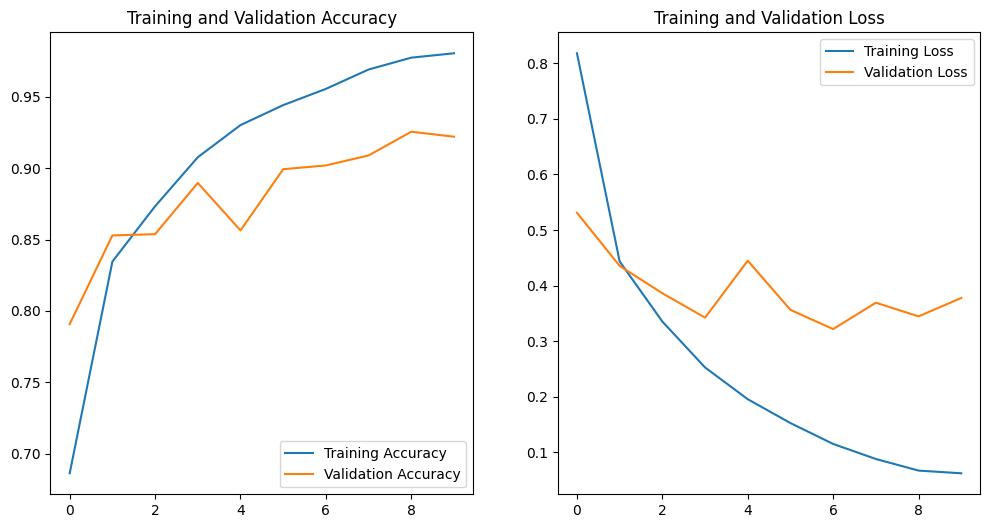

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 221ms/step
Baseline Accuracy: 92.22%

              precision    recall  f1-score   support

      glioma       0.87      0.90      0.89       300
  meningioma       0.89      0.80      0.84       306
     notumor       0.96      0.99      0.97       405
   pituitary       0.95      0.98      0.96       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



,glioma,meningioma,notumor,pituitary
glioma,271,25,1,3
meningioma,34,244,14,14
notumor,2,4,399,0
pituitary,4,1,0,295


In [63]:
# Baseline CNN model with dropout


do_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(.3),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


model_training_and_evaluation(do_model, train_ds, val_ds, epochs)

Epoch 1/20
143/143 [==============================] - 94s 631ms/step - loss: 2.4345 - accuracy: 0.6606 - val_loss: 0.8729 - val_accuracy: 0.8047
Epoch 2/20
143/143 [==============================] - 72s 506ms/step - loss: 0.7864 - accuracy: 0.8090 - val_loss: 0.6987 - val_accuracy: 0.8468
Epoch 3/20
143/143 [==============================] - 73s 511ms/step - loss: 0.6530 - accuracy: 0.8348 - val_loss: 0.5950 - val_accuracy: 0.8687
Epoch 4/20
143/143 [==============================] - 71s 496ms/step - loss: 0.5520 - accuracy: 0.8722 - val_loss: 0.5407 - val_accuracy: 0.8835
Epoch 5/20
143/143 [==============================] - 71s 496ms/step - loss: 0.4928 - accuracy: 0.8807 - val_loss: 0.5113 - val_accuracy: 0.8905
Epoch 6/20
143/143 [==============================] - 73s 509ms/step - loss: 0.4396 - accuracy: 0.8987 - val_loss: 0.4856 - val_accuracy: 0.8940
Epoch 7/20
143/143 [==============================] - 73s 510ms/step - loss: 0.3813 - accuracy: 0.9239 - val_loss: 0.4628 - val_ac

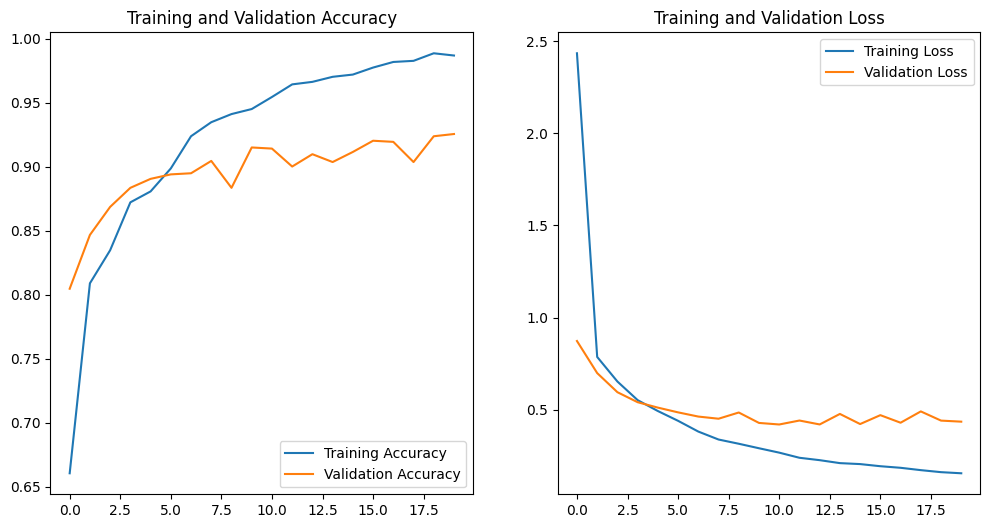

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 200ms/step
Baseline Accuracy: 93.14%

              precision    recall  f1-score   support

      glioma       0.94      0.88      0.91       300
  meningioma       0.84      0.89      0.86       306
     notumor       0.97      0.98      0.97       405
   pituitary       0.98      0.96      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



,glioma,meningioma,notumor,pituitary
glioma,264,34,1,1
meningioma,16,272,12,6
notumor,2,7,396,0
pituitary,0,11,0,289


In [65]:
# Baseline CNN model with regularizers and dropout
from tensorflow.keras import regularizers
num_classes = len(classes)
img_height, img_width = IMG_DIMS
epochs=20


reg_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer='l1_l2'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer='l1_l2'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer='l1_l2'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


model_training_and_evaluation(reg_model, train_ds, val_ds, epochs)


In [66]:
class_weight_dict = { 0 : 1.5, 1:1.5, 2:1, 3:1}
class_weight_dict

{0: 1.5, 1: 1.5, 2: 1, 3: 1}

Epoch 1/20
143/143 [==============================] - 84s 576ms/step - loss: 0.9639 - accuracy: 0.6919 - val_loss: 0.4747 - val_accuracy: 0.8380
Epoch 2/20
143/143 [==============================] - 76s 529ms/step - loss: 0.5175 - accuracy: 0.8466 - val_loss: 0.4539 - val_accuracy: 0.8231
Epoch 3/20
143/143 [==============================] - 72s 507ms/step - loss: 0.3574 - accuracy: 0.9037 - val_loss: 0.2991 - val_accuracy: 0.8993
Epoch 4/20
143/143 [==============================] - 74s 519ms/step - loss: 0.2567 - accuracy: 0.9376 - val_loss: 0.2975 - val_accuracy: 0.9194
Epoch 5/20
143/143 [==============================] - 80s 564ms/step - loss: 0.1644 - accuracy: 0.9586 - val_loss: 0.2312 - val_accuracy: 0.9335
Epoch 6/20
143/143 [==============================] - 75s 528ms/step - loss: 0.1295 - accuracy: 0.9672 - val_loss: 0.3151 - val_accuracy: 0.9081
Epoch 7/20
143/143 [==============================] - 76s 528ms/step - loss: 0.0895 - accuracy: 0.9801 - val_loss: 0.2471 - val_ac

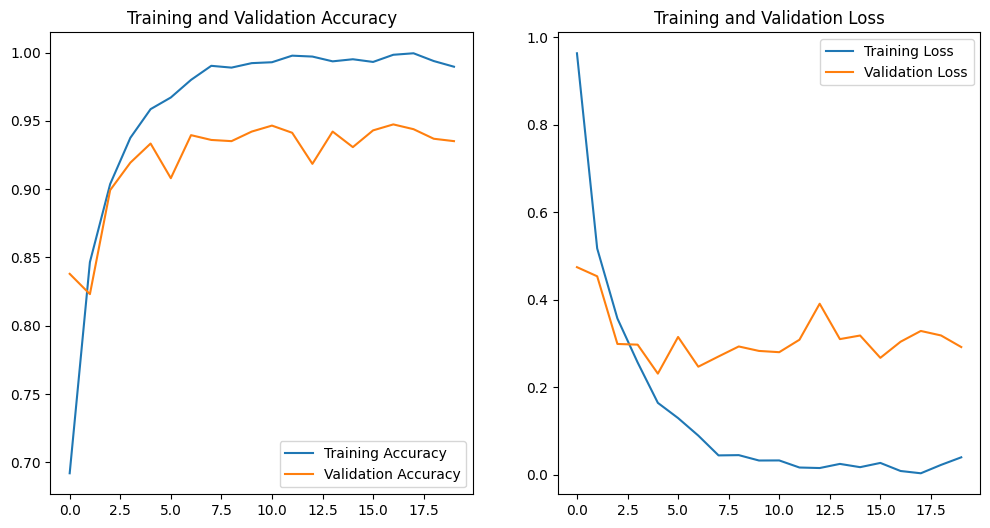

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 199ms/step
Baseline Accuracy: 94.36%

              precision    recall  f1-score   support

      glioma       0.96      0.90      0.93       300
  meningioma       0.91      0.89      0.90       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



,glioma,meningioma,notumor,pituitary
glioma,270,18,3,9
meningioma,12,271,17,6
notumor,0,6,399,0
pituitary,0,2,1,297


In [67]:
# Baseline CNN model with dropout and class weights

cw_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(.3),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


model_training_and_evaluation(cw_model, train_ds, val_ds, epochs, class_weights = class_weight_dict)

In [68]:
def lr_function(epoch):
    start_lr = 1e-6; min_lr = 1e-6; max_lr = 1e-4
    rampup_epochs = 5; sustain_epochs = 0; exp_decay = .8

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr,
              rampup_epochs, sustain_epochs, exp_decay)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/20
143/143 [==============================] - 76s 523ms/step - loss: 1.6021 - accuracy: 0.4593 - val_loss: 1.2096 - val_accuracy: 0.5788 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 2.08e-05.
Epoch 2/20
143/143 [==============================] - 74s 515ms/step - loss: 1.0357 - accuracy: 0.6858 - val_loss: 0.6575 - val_accuracy: 0.7723 - lr: 2.0800e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.06e-05.
Epoch 3/20
143/143 [==============================] - 76s 534ms/step - loss: 0.6946 - accuracy: 0.7998 - val_loss: 0.5269 - val_accuracy: 0.8152 - lr: 4.0600e-05

Epoch 4: LearningRateScheduler setting learning rate to 6.04e-05.
Epoch 4/20
143/143 [==============================] - 92s 645ms/step - loss: 0.5716 - accuracy: 0.8431 - val_loss: 0.5573 - val_accuracy: 0.7968 - lr: 6.0400e-05

Epoch 5: LearningRateScheduler setting learning rate to 8.02e-05.
Epoch 5/20
143/143 [

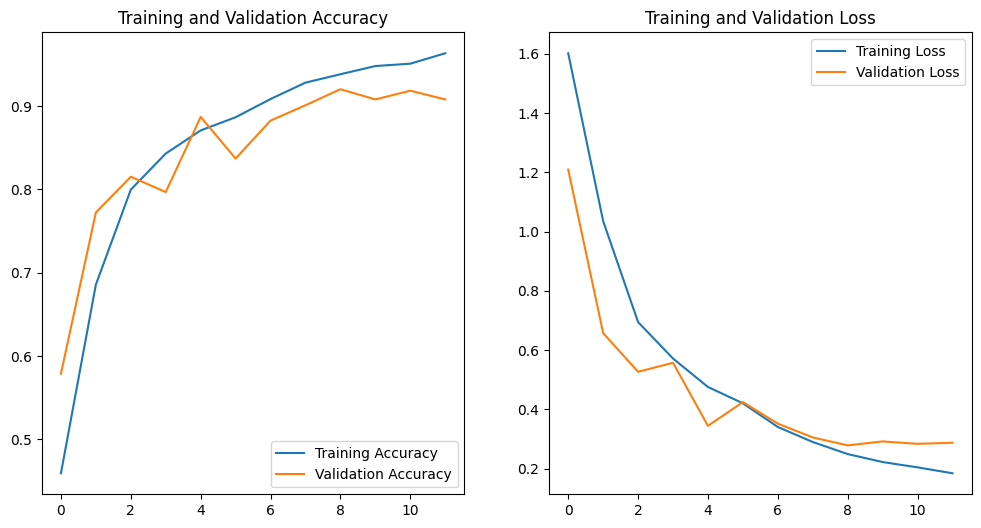

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 193ms/step
Baseline Accuracy: 89.32%

              precision    recall  f1-score   support

      glioma       0.88      0.84      0.86       300
  meningioma       0.83      0.75      0.79       306
     notumor       0.92      0.97      0.95       405
   pituitary       0.91      0.98      0.95       300

    accuracy                           0.89      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.89      0.89      0.89      1311



,glioma,meningioma,notumor,pituitary
glioma,252,39,3,6
meningioma,28,230,27,21
notumor,4,6,394,1
pituitary,1,2,2,295


In [69]:
# Baseline CNN model with learning rate and early stopping

num_classes = len(classes)
img_height, img_width = IMG_DIMS

baseline_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_function(epoch), verbose=True)
    ]

model_training_and_evaluation(baseline_model, train_ds, val_ds, epochs, class_weights = class_weight_dict, callbacks=callbacks)



Transfer learning with ResNet50

In [70]:
#ResNet50 Model (bottom not trainable)
model_name = 'resnet50_v01'


# load a new instance of the model withut the top
resnet50_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_DIMS+(3,),
                                                         include_top=False,
                                                         weights='imagenet',
                                                         )
#I block the convolutional part of the network
resnet50_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [71]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [72]:
num_classes = 4

tl_resnet = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_DIMS+(3,)),
  resnet50_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(256),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

tl_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])



In [73]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)


In [ ]:
history = tl_resnet.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks = [early_stopping_cb],
                    )

Epoch 1/20
 54/143 [==========>...................] - ETA: 2:31 - loss: 1.2887 - accuracy: 0.4233